In [37]:
import pandas as pd
from print_nanny_webapp.client_events.models import PredictEvent, AlertMessage
from django.utils import timezone
from asgiref.sync import sync_to_async
import os
import uuid

import matplotlib


In [38]:
CONFIDENCE_THRESHOLD = 0.50

LABELS = {
    1: 'nozzle',
    2: 'adhesion',
    3: 'spaghetti',
    4: 'print',
    5: 'raft',
}

FAILURES = {
    2: 'adhesion',
    3: 'spaghetti',  
}


In [39]:
import json
def dict_to_series(data):
    return pd.Series(data.values(), index=data.keys())

In [40]:
predict_events = PredictEvent.objects.all().order_by('-dt').values('id','predict_data')

df = pd.DataFrame.from_records(predict_events, index='id')
df = df['predict_data'].apply(dict_to_series)

NUM_DETECTIONS = len(df['detection_scores'].iloc[0])
print(NUM_DETECTIONS)

40


In [41]:
df = df.dropna()
df = df[['detection_classes', 'detection_scores']]
df = df.reset_index()
df = df.rename(columns={'id': 'frame_id' })

NUM_FRAMES = len(df)
df

,frame_id,detection_classes,detection_scores
0,73,"[3, 4, 3, 2, 4, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, ...","[0.91015625, 0.66015625, 0.2109375, 0.16015625..."
1,72,"[5, 4, 2, 2, 3, 2, 2, 2, 2, 5, 2, 3, 4, 2, 3, ...","[0.73046875, 0.58203125, 0.41796875, 0.4179687..."
2,71,"[5, 4, 2, 1, 2, 2, 3, 3, 3, 4, 5, 2, 2, 4, 5, ...","[0.83984375, 0.66015625, 0.33984375, 0.2109375..."
3,70,"[3, 4, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, ...","[0.58203125, 0.33984375, 0.16015625, 0.1210937..."
4,69,"[3, 4, 2, 4, 3, 2, 3, 2, 3, 4, 3, 3, 3, 4, 3, ...","[0.83984375, 0.5, 0.16015625, 0.16015625, 0.03..."
...,...,...,...
68,5,"[4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, ...","[0.58203125, 0.08984375, 0.08984375, 0.0898437..."
69,4,"[4, 4, 4, 5, 5, 1, 1, 3, 4, 4, 4, 4, 1, 4, 4, ...","[0.58203125, 0.33984375, 0.16015625, 0.1210937..."
70,3,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, ...","[0.16015625, 0.08984375, 0.05078125, 0.0507812..."
71,2,"[4, 4, 4, 3, 1, 1, 1, 3, 1, 4, 4, 3, 4, 4, 3, ...","[0.16015625, 0.08984375, 0.08984375, 0.0664062..."


In [42]:
print('Explode detection_classes and detection_scores together')
df = df.set_index(['frame_id']).apply(pd.Series.explode).reset_index()

assert len(df) == NUM_FRAMES * NUM_DETECTIONS
df

Explode detection_classes and detection_scores together


,frame_id,detection_classes,detection_scores
0,73,3,0.910156
1,73,4,0.660156
2,73,3,0.210938
3,73,2,0.160156
4,73,4,0.160156
...,...,...,...
2915,1,4,0.0117188
2916,1,1,0.0117188
2917,1,4,0.0117188
2918,1,3,0.0117188


In [43]:
print('Add labels')
df['label'] = df['detection_classes'].map(LABELS)
df


Add labels


,frame_id,detection_classes,detection_scores,label
0,73,3,0.910156,spaghetti
1,73,4,0.660156,print
2,73,3,0.210938,spaghetti
3,73,2,0.160156,adhesion
4,73,4,0.160156,print
...,...,...,...,...
2915,1,4,0.0117188,print
2916,1,1,0.0117188,nozzle
2917,1,4,0.0117188,print
2918,1,3,0.0117188,spaghetti


In [44]:
print('Create a hierarchal index')
df = df.set_index(['frame_id', 'label'])
df

Create a hierarchal index


detection_classes detection_scores
frame_id label                                       
73       spaghetti                 3         0.910156
         print                     4         0.660156
         spaghetti                 3         0.210938
         adhesion                  2         0.160156
         print                     4         0.160156
...                              ...              ...
1        print                     4        0.0117188
         nozzle                    1        0.0117188
         print                     4        0.0117188
         spaghetti                 3        0.0117188
         adhesion                  2        0.0117188

[2920 rows x 2 columns]

Distribution of confidences


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

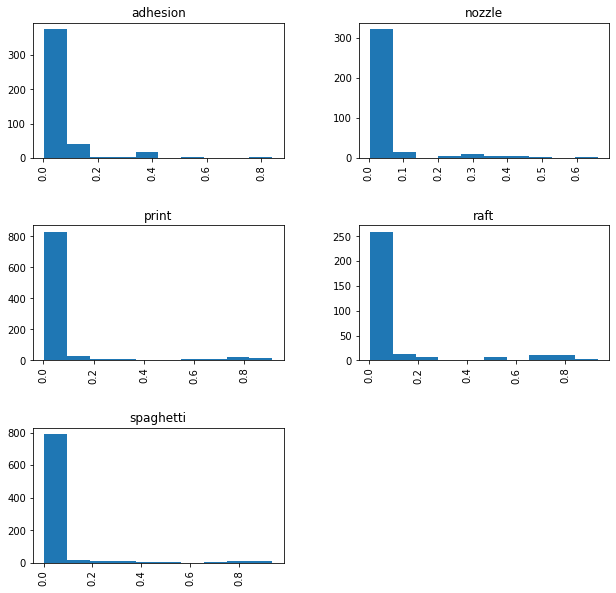

In [45]:
print(f'Distribution of confidences')
df['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidences > 0.5


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

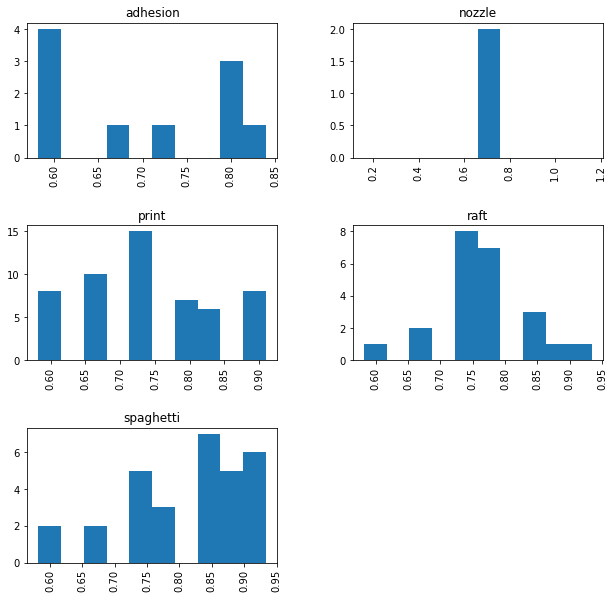

In [46]:
print(f'Distribution of confidences > {CONFIDENCE_THRESHOLD}')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidence scores > THRESHOLD, FAILURE vs. OK


array([<AxesSubplot:title={'center':'FAILURE'}>,
       <AxesSubplot:title={'center':'NEUTRAL'}>], dtype=object)

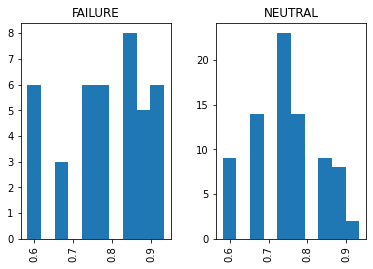

In [47]:
print('Distribution of confidence scores > THRESHOLD, FAILURE vs. OK')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by=lambda x: 'FAILURE' if x[1] in FAILURES.values() else 'NEUTRAL' )


In [48]:
print('Frames where at least 1 type of failure is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (df['detection_classes'].isin(FAILURES))

fail_df = df[mask]

fail_df

Frames where at least 1 type of failure is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
73,spaghetti,3,0.910156
70,spaghetti,3,0.582031
69,spaghetti,3,0.839844
68,spaghetti,3,0.878906
65,spaghetti,3,0.839844
64,spaghetti,3,0.730469
63,spaghetti,3,0.839844
62,adhesion,2,0.789062
61,adhesion,2,0.660156


In [49]:
print('Percent of frames where at least 1 type of failure is confidently detected')
(len(fail_df) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of failure is confidently detected


54.794520547945204

In [50]:
print('Frames where at least 1 type of neutral is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (~df['detection_classes'].isin(FAILURES))

neutral_df = df[mask]

neutral_df 

Frames where at least 1 type of neutral is confidently detected


detection_classes detection_scores
frame_id label                                   
73       print                 4         0.660156
72       raft                  5         0.730469
         print                 4         0.582031
71       raft                  5         0.839844
         print                 4         0.660156
...                          ...              ...
9        print                 4         0.730469
8        print                 4         0.730469
7        print                 4         0.730469
5        print                 4         0.582031
4        print                 4         0.582031

[79 rows x 2 columns]

In [51]:
print('Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected')
(len(neutral_df ) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected


108.21917808219179

In [52]:
print('Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected')

len(fail_df) / (len(neutral_df ))

Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected


0.5063291139240507

In [53]:
tuple(df[df['detection_scores'] > CONFIDENCE_THRESHOLD].groupby(level='label').size().items())

(('adhesion', 10),
 ('nozzle', 2),
 ('print', 54),
 ('raft', 23),
 ('spaghetti', 30))

In [55]:
fail_df.groupby('frame_id').size()
neutral_df.groupby('frame_id').size()

confident_df = df[df['detection_scores'] > CONFIDENCE_THRESHOLD]

import imageio

def send_email_notification(fail_df, ratio=0.55):
    frame_ids = [frame_id for frame_id, _ in fail_df.index]

    predict_events = PredictEvent.objects.filter(
        id__in=frame_ids,        
    ).order_by('dt').all()

    print_job = predict_events[0].print_job

    alert_message = AlertMessage.objects.filter(
        print_job=print_job.id
    ).first()

    if alert_message is not None:
        logging.warning('Alert for print job {print_job} already sent at {alert_message.created_dt}, skipping')
        return

    images = [ 
        imageio.imread(event.files.annotated_image.file.url)
        for event in predict_events
    ]

    buff = BytesIO
    buff.name = uuid.uuid4()
    gif = imageio.imsave(buff, images, fps=60)

    alert_message = AlertMessage.create(
        user,
        print_job,
        video=gif,
        dataframe=fail_df.to_dict()
    )

    merge_data = {
        'RATIO': '{:.2%}'.format(ratio),
        'GCODE_FILE': print_job.gcode_file.name,
        'VIDEO_URL': alert_message.video.url,
        'STOP_URL': f'http://localhost/feedback/{alert_message.id}?action=stop_print',
        'SILENCE_URL': f'http://localhost/feedback/{alert_message.id}?action=silence',
        'RESUME_URL': f'http://localhost/feedback/{alert_message.id}?action=resume',
        'FIRST_NAME': print_job.user.first_name or 'Maker',
    }

    subject = render_to_string("message_subject.txt", merge_data).strip()
    text_body = render_to_string("message_body.txt", merge_data)
    html_body = render_to_string("message_body.html", merge_data)

    message = AnymailMessage(
        subject=subject,
        body=text_body,
        to=[predict_events[0].user.email],
        tags=["default-print-alert"],  # Anymail extra in constructor
    )
    message.attach_alternative(html_body, 'text/html')
    message.send()

send_email_notification(fail_df)


ProgrammingError: relation "client_events_alertmessage" does not exist
LINE 1: ...s", "client_events_alertmessage"."dataframe" FROM "client_ev...
                                                             ^


In [57]:
from django.conf import settings
from django.urls import URLResolver, URLPattern

root_urlconf = __import__(settings.ROOT_URLCONF) # import root_urlconf module
all_urlpatterns = root_urlconf.urls.urlpatterns # project's urlpatterns
VIEW_NAMES = [] # maintain a global list

def get_all_view_names(urlpatterns):
    global VIEW_NAMES
    for pattern in urlpatterns:
        if isinstance(pattern, URLResolver):
            get_all_view_names(pattern.url_patterns) # call this function recursively
        elif isinstance(pattern, URLPattern):
            view_name = pattern.callback.)__name__ # get the view name
            VIEW_NAMES.append(view_name) # add the view to the global list 
    return VIEW_NAMES

get_all_view_names(all_urlpatterns)

AttributeError: 'function' object has no attribute 'func_name'